# SGDによる線形分類モデル

[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
は、確率的勾配降下法 (SGD) を使った線形分類モデルを提供しています。
SGDClassifier の `loss` と `penalty` を変えることで、SGDでの最適化による SVM やロジスティック回帰を
使うことができます。

```{note}

SGDについてはscikit-learnの公式ドキュメントが詳しいです。

https://scikit-learn.org/stable/modules/sgd.html#sgd

ドキュメント内に
[数式による目的関数との対応](https://scikit-learn.org/stable/modules/sgd.html#mathematical-formulation)
も書かれています。
```

ここでは、 SGDClassifier の使い方のレシピをまとめます。

SGDClassifierでは次の式が目的関数になります。

$$
  E(w, b) = \frac{1}{n} \sum_{i=1}^{n} L(y_i, f(x_i)) + \alpha R(w)
$$

この $L$ と `loss`, $R$ を `penalty` パラメータで設定することで、目的関数を定めます。

**データとモジュールのロード**

In [1]:
import pandas as pd
from sklearn import model_selection

data = pd.read_csv("input/pn_same_judge_preprocessed.csv")
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import PrecisionRecallDisplay

## SVM

SGDClassifierのデフォルトのパラメータはオンラインSVMに対応しています。

\begin{align}
  L(y_i, f(x_i)) &= \max(0, 1 - y_i f(x_i)) \\
  R(w) &= ||w||_2^2
\end{align}

$R$ がマージンに、そして $L$ がソフトマージンのペナルティに対応しています。

In [3]:
from sklearn.linear_model import SGDClassifier

In [4]:
sgd = SGDClassifier()

In [5]:
sgd.loss, sgd.penalty, sgd.alpha

('hinge', 'l2', 0.0001)

では実際に学習を行ってみます。
学習の際には、確率的勾配降下法のサンプルの順を固定して再現性を保つように `random_state` を付与しておきます。

In [6]:
pipe_svm = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=str.split)),
    ("clf", SGDClassifier(random_state=0)),
])

In [7]:
pipe_svm.fit(X=train["tokens"], y=train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<method 'split' of 'str' objects>)),
                ('clf', SGDClassifier(random_state=0))])

In [8]:
score_svm = pipe_svm.decision_function(test["tokens"])

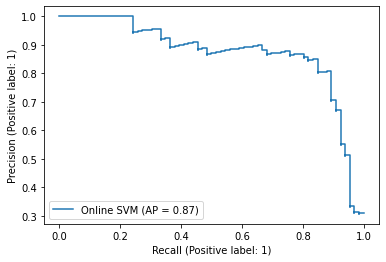

In [9]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_svm,
    name="Online SVM",
)

$\alpha$ や、確率的勾配降下法のイテレーション数も変更できます。

scikit-learn のドキュメント
[Working With Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#evaluation-of-the-performance-on-the-test-set)
に出てくる設定で学習してみましょう。

In [10]:
pipe_svm = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=str.split)),
    ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

In [11]:
pipe_svm.fit(X=train["tokens"], y=train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<method 'split' of 'str' objects>)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

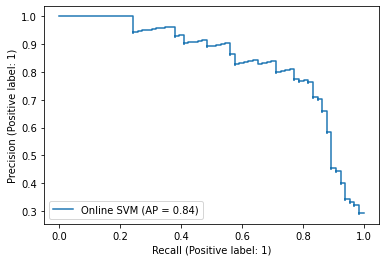

In [12]:
score_svm = pipe_svm.decision_function(test["tokens"])
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_svm,
    name="Online SVM",
)

## ロジスティック回帰

SGDClassifierで `loss` を `log_loss` にすることで、以下の目的関数を最適化するロジスティック回帰モデルに対応します。

\begin{align}
L(y_i, f(x_i)) &= \log(1 + \exp(- y_i f(x_i)) \\
R(w) &= ||w||_2^2
\end{align}

学習してみましょう。

In [13]:
pipe_log = Pipeline([
    ("vect", TfidfVectorizer(tokenizer=str.split)),
    ("clf", SGDClassifier(loss="log_loss", random_state=0)),
])

In [14]:
pipe_log.fit(X=train["tokens"], y=train["label_num"])

Pipeline(steps=[('vect',
                 TfidfVectorizer(tokenizer=<method 'split' of 'str' objects>)),
                ('clf', SGDClassifier(loss='log_loss', random_state=0))])

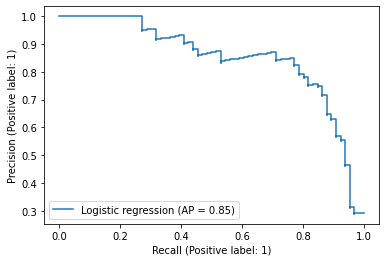

In [15]:
score_log = pipe_log.predict_proba(test["tokens"])[:,1]
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_log,
    name="Logistic regression",
)

## 特徴量の重要度

SGDClassifierは線形分類器なので、特徴量の重みを見ることでその重要度を知ることができます。
特徴量の重みは `coef_` で取得します。

In [16]:
coef = pipe_svm["clf"].coef_

In [17]:
coef.shape

(1, 3069)

特徴量のインデックスに対応するトークンを取得して、トークン毎の重要度を見てみましょう。

In [18]:
tokens = pipe_svm["vect"].get_feature_names_out()

In [19]:
tokens.shape

(3069,)

In [20]:
importance_df = pd.DataFrame({
    "importance": coef[0],
    "token": tokens,
})

ソートして重要度が高いものからいくつか表示してみましょう。

In [22]:
# ラベルが 1 （つまり意見がネガティブ）側の重要なトークン
importance_df.sort_values("importance", ascending=False).head(30)

,importance,token
2159,3.668755,残念
2353,2.423272,狭い
1851,1.956964,悪い
1696,1.739485,少し
619,1.634807,イマイチ
1416,1.532445,古い
335,1.509603,ただ
430,1.487909,ない
370,1.466131,ちょっと
2142,1.435011,欲しい


In [23]:
# ラベルが 0 (つまり意見はポジティブ）側の重要なトークン
importance_df.sort_values("importance").head(30)

,importance,token
2612,-0.955972,良い
518,-0.928854,ます
2563,-0.644084,美味しい
2052,-0.631138,最高
958,-0.594304,ホテル
2549,-0.583404,綺麗
2374,-0.552146,申し分
218,-0.537186,くれる
119,-0.530833,ある
2295,-0.510448,満足


単語を見ると意見のポジティブ、ネガティブを反映して特徴量である各トークンに重要度が与えられていることがわかります。